# Landsat Thermal Sharpening Example

In [1]:
import pprint

import ee
from IPython.display import Image

import openet.sharpen

ee.Initialize(use_cloud_api=True)


In [2]:
viridis_palette = ['#440154', '#433982', '#30678D', '#218F8B', '#36B677', '#8ED542', '#FDE725']

image_size = 768


In [3]:
# landsat_id = 'LC08_044033_20170918'  # Cloudy, some clear areas over northern CV
landsat_id = 'LC08_042034_20180705'  # Clear
landsat_sr_img = ee.Image('LANDSAT/LC08/C01/T1_SR/{}'.format(landsat_id))


In [4]:
site_xy = [-120.105, 36.95]
# site_xy = [-120.10237, 36.946608]
dx = 0.012
dy = 0.006
study_geom = ee.Geometry.Rectangle(site_xy[0]-dx, site_xy[1]-dy, site_xy[0]+dx, site_xy[1]+dy)
study_region = study_geom.bounds(1, 'EPSG:4326')


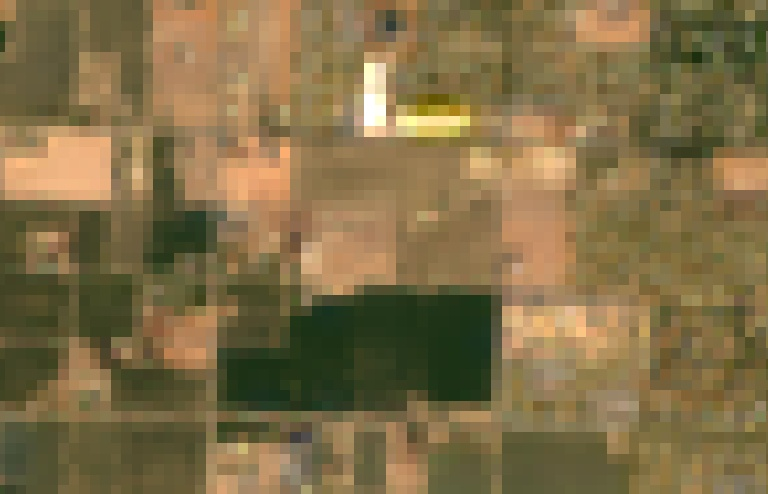

In [5]:
image_url = landsat_sr_img.select([3, 2, 1])\
    .getThumbURL({'min': 0.0, 'max': 3000, 
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


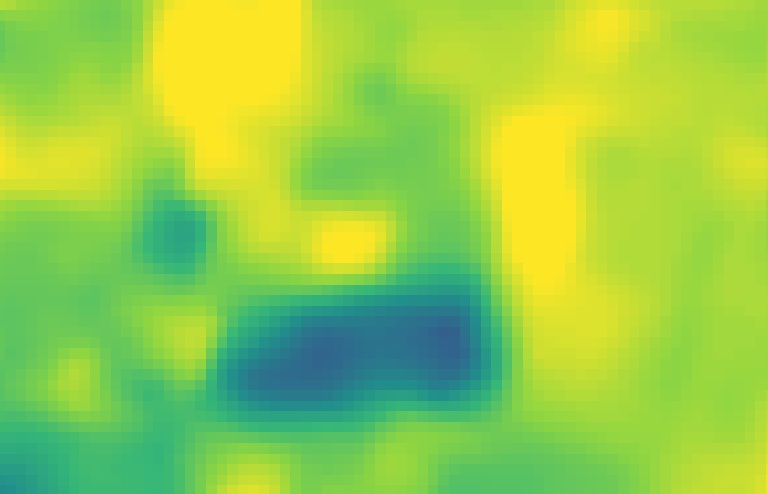

In [6]:
image_url = landsat_sr_img.select(['B10'])\
    .getThumbURL({'min': 2950, 'max': 3150, 'palette': viridis_palette,
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


## Prepare the Landsat image for sharpening

This primarily consists of standardizing the band names.

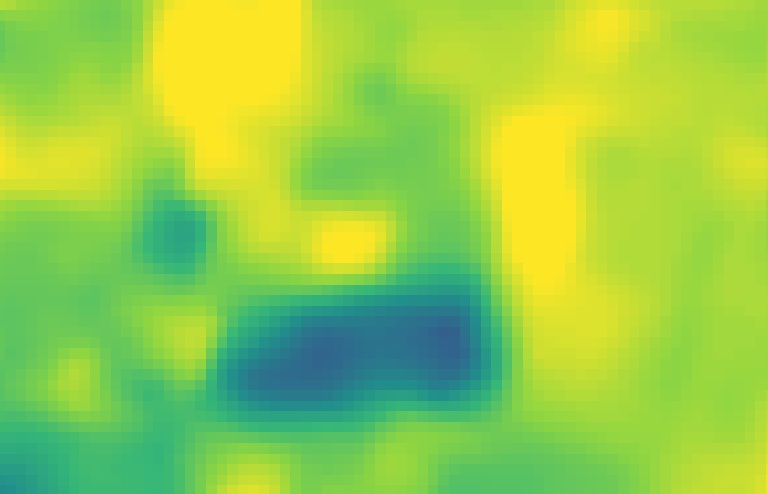

In [7]:
# Copied from PTJPL Image.from_landsat_c1_sr()
# CGM - The "SATELLITE" property must be set on the image for the algorithm to work
input_bands = ee.Dictionary({
    'LANDSAT_5': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6', 'pixel_qa'],
    'LANDSAT_7': ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B6', 'pixel_qa'],
    'LANDSAT_8': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'pixel_qa']})
output_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'tir', 'pixel_qa']
spacecraft_id = ee.String(landsat_sr_img.get('SATELLITE'))
prep_img = landsat_sr_img \
    .select(input_bands.get(spacecraft_id), output_bands) \
    .multiply([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.1, 1]) \
    .set({'system:index': landsat_sr_img.get('system:index'),
          'system:time_start': landsat_sr_img.get('system:time_start'),
          'system:id': landsat_sr_img.get('system:id'), 
          'SATELLITE': spacecraft_id,
         })

image_url = prep_img.select(['tir'])\
    .getThumbURL({'min': 295, 'max': 315, 'palette': viridis_palette,
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


## Run the thermal sharpening

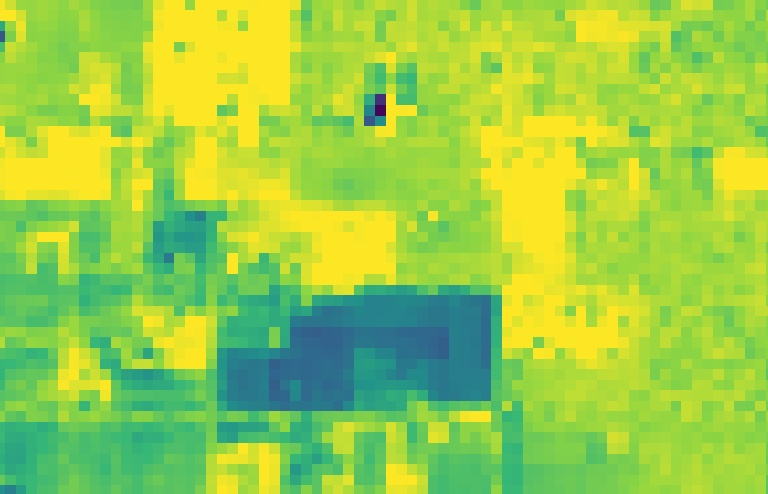

In [8]:
output_img = openet.sharpen.thermal.landsat(prep_img)

image_url = output_img.select(['tir_sharpened'])\
    .getThumbURL({'min': 295, 'max': 315, 'palette': viridis_palette,
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


In [9]:
pprint.pprint(output_img.bandNames().getInfo())

# image_url = output_img.select(['tir_orig'])\
#     .getThumbURL({'min': 290, 'max': 315, 'dimensions':512, 'region': study_region})
# Image(url=image_url, embed=True, format='png')


['tir_sharpened',
 'tir_original',
 'tir_agg',
 'tir_sp_local',
 'tir_sp_global',
 'tir_local_agg',
 'tir_global_agg',
 'local_weights',
 'slr_rmse']


In [10]:
def point_image_value(image, xy, scale=1):
    """Extract the output value from a calculation at a point"""
    return ee.Image(image).reduceRegion(
        reducer=ee.Reducer.first(), geometry=ee.Geometry.Point(xy),
        scale=scale).getInfo()

pprint.pprint(point_image_value(prep_img.select(['tir']), site_xy, scale=1))
pprint.pprint(point_image_value(output_img.select(['tir_original']), site_xy, scale=1))
pprint.pprint(point_image_value(output_img.select(['tir_sharpened']), site_xy, scale=1))


{'tir': 313.90000000000003}
{'tir_original': 313.90000000000003}
{'tir_sharpened': 315.501853528282}
